In [15]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from math import sqrt


In [16]:
links = []
list_html = []
list_html0 = []
carname = []
listing_data = []
prices = []


for page in range(1,14,1):
    url = f'https://www.autouncle.dk/da/brugte-biler/f-benzin?page={page}&search_form=1'
    links.append(url)
    
for url in links:
    response = requests.get(url, headers={'email':'ptj867@alumni.ku.dk', 'Purpose':'For exam project'})
    time.sleep(2)
    list_html.append(response)

for url0 in list_html:
    soup = BeautifulSoup(url0.content, 'lxml')
    list_html0.append(soup)
    
for element in list_html0:
    inner_rows = element.find_all('a', class_='listing-item-headline truncated')
    carname.append(inner_rows)

flat_list = [item for sublist in carname for item in sublist]
carname_df = pd.DataFrame(flat_list)


for data in list_html0:
    inner_rows1 = data.find_all('div', class_='listing-item-info-chip')
    listing_data+=inner_rows1

Year = [
    [div_element for div_element in inner_list if re.search(r"\d{4}", div_element.get_text())]
    for inner_list in listing_data
]

KM = [
    [div_element for div_element in inner_list if "km" in div_element.get_text()]
    for inner_list in listing_data
]
Motor = [
    [div_element for div_element in inner_list if "Benzin" in div_element.get_text()]
    for inner_list in listing_data
]
Gear = [
    [div_element for div_element in inner_list if "gear" in div_element.get_text()]
    for inner_list in listing_data
]
HK = [
    [div_element for div_element in inner_list if "HK" in div_element.get_text()]
    for inner_list in listing_data
]
df = pd.DataFrame({'Year':Year,'KM':KM, 'Motor':Motor, 'Gear':Gear, 'HK':HK})
df = df[df.applymap(lambda x: x != []).any(axis=1)]
df['Year'] = df['Year'].shift(4)
df['KM'] = df['KM'].shift(3)
df['Motor'] = df['Motor'].shift(2)
df['Gear'] = df['Gear'].shift(1)
df = df.applymap(lambda x: [] if 'CO2' in str(x) else x)
df = df.applymap(lambda x: [] if x is None else x)
df = df[df.applymap(lambda x: x != []).any(axis=1)]
df.reset_index(inplace=True)


for price in list_html0:    
    inner_rows2 = price.find_all('div', class_='listing-item-price')
    prices+= inner_rows2  # Append the text, not the element itself
pricesdf = pd.DataFrame({'Price': prices})
pricesdf

def extract_numeric_value(cell):
    match = re.search(r'\d+\.\d+', cell)
    if match:
        return match.group()
    else:
        return None

cleaned_prices = pricesdf.applymap(lambda cell: extract_numeric_value(str(cell)))

final_data = pd.concat([carname_df, cleaned_prices, df], axis=1)
final_data = final_data.drop(columns=['index'])

columns = ['Title','Price (DKK)', 'Year', 'KM driven', 'Motor (Litres)', 'Transmission', 'Horsepower']
final_data.columns=columns


In [17]:
#Removing brackets and quotations marks from all cells
for col in columns:
    final_data[col] = final_data[col].astype(str).str.replace(r'\[|\]','', regex=True).str.replace(r'\'|\'','', regex=True)

#Cleaning up the dataset, converting integers, strings etc.  
final_data['KM driven'] = final_data['KM driven'].str.replace(' km', '').str.replace('.', '').astype(int)
final_data['Motor (Litres)'] = final_data['Motor (Litres)'].str.replace('L Benzin', '').astype(float)
final_data['Price (DKK)']= final_data['Price (DKK)'].str.replace('.', '').astype(int)

#Cleansing the Horsepower column for letters, such it can be converted to an interger
final_data['Horsepower'] = final_data['Horsepower'].str.replace(r'\(.*\)', '', regex=True).str.replace(r'\D', '', regex=True).str.strip()
final_data = final_data[final_data['Horsepower'] != '']
final_data['Horsepower'] = final_data['Horsepower'].astype(int)

#Removing months from the year column
final_data['Year'] = final_data['Year'].str.replace(r'\D', '', regex=True).astype(int)

#Creating new 'Car Manufacturer' column by extracting the first word of the 'Title'column.
final_data['Car Manufacturer'] = final_data['Title'].str.split().str[0].astype(str)



#Cleaning the 'Title' column
final_data['Title'] = final_data['Title'].str.rstrip('aut. \n')

#Import Car Manufacturer Specs and merge it with 'final_data' in order to include the 'country of origin'-column
car_manufacturer_specs = pd.read_csv('Car Manufacturer Specification.csv', sep=';')
final_data = pd.merge(final_data, car_manufacturer_specs, on='Car Manufacturer')


final_data

FileNotFoundError: [Errno 2] No such file or directory: 'Car Manufacturer Specification.csv'

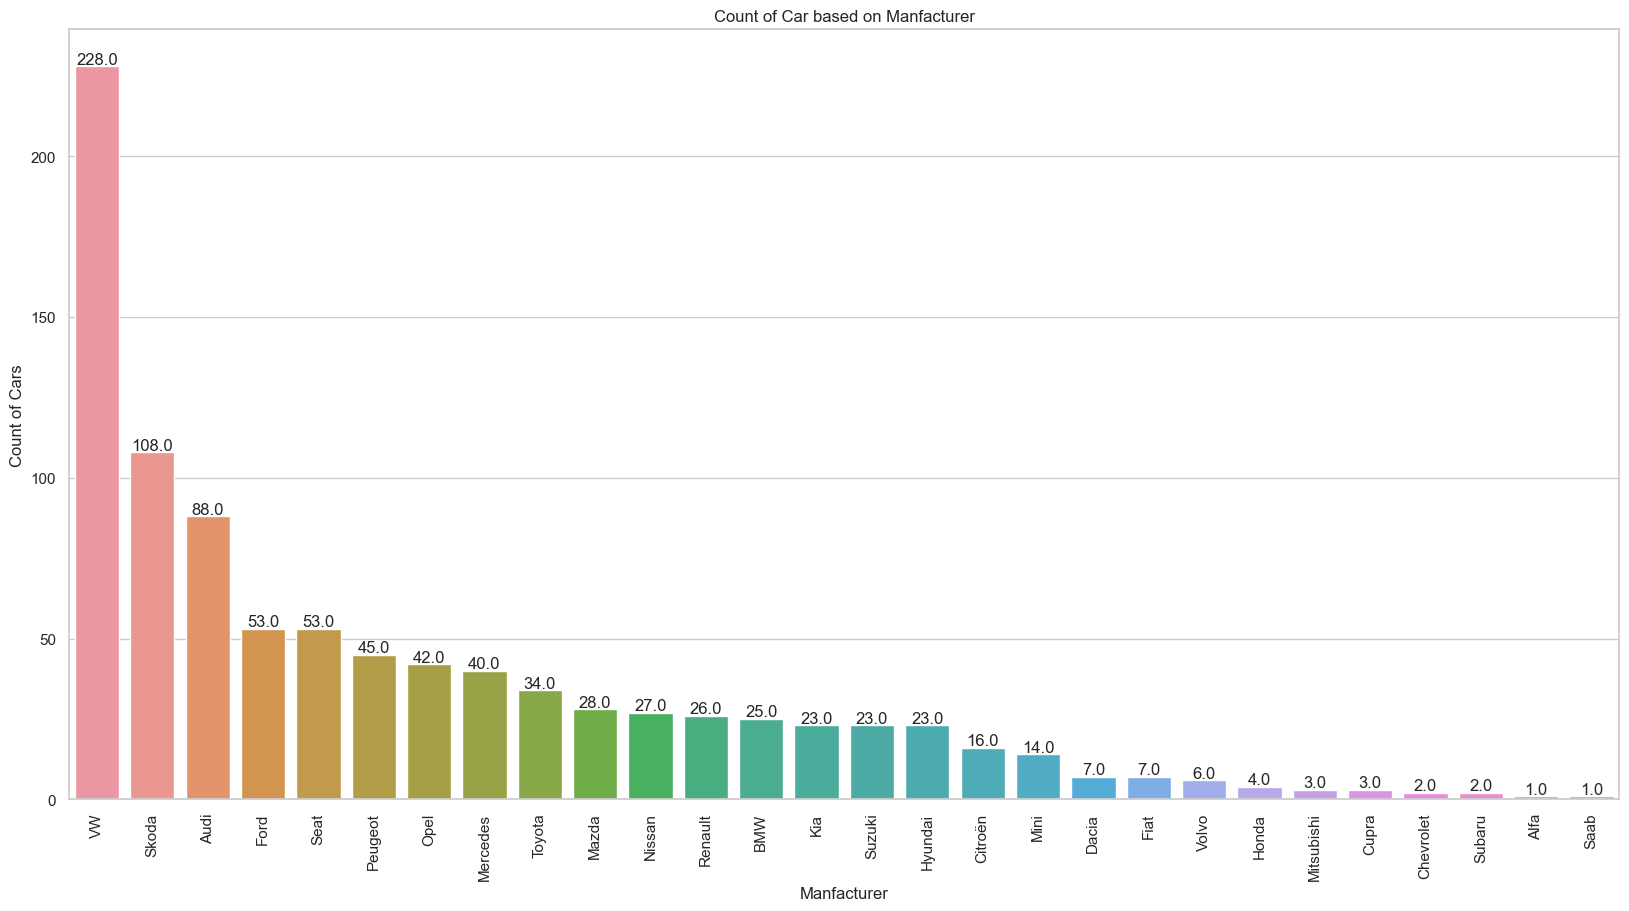

In [ ]:
plt.rcParams['figure.figsize'] = 20,10
Cars = final_data['Car Manufacturer'].value_counts()
plot = sns.barplot(x = Cars.index,y = Cars.values,data = df)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Car based on Manfacturer')
plt.xlabel('Manfacturer')
plt.ylabel('Count of Cars')
plt.savefig('Count of Cars.png')
plt.show()

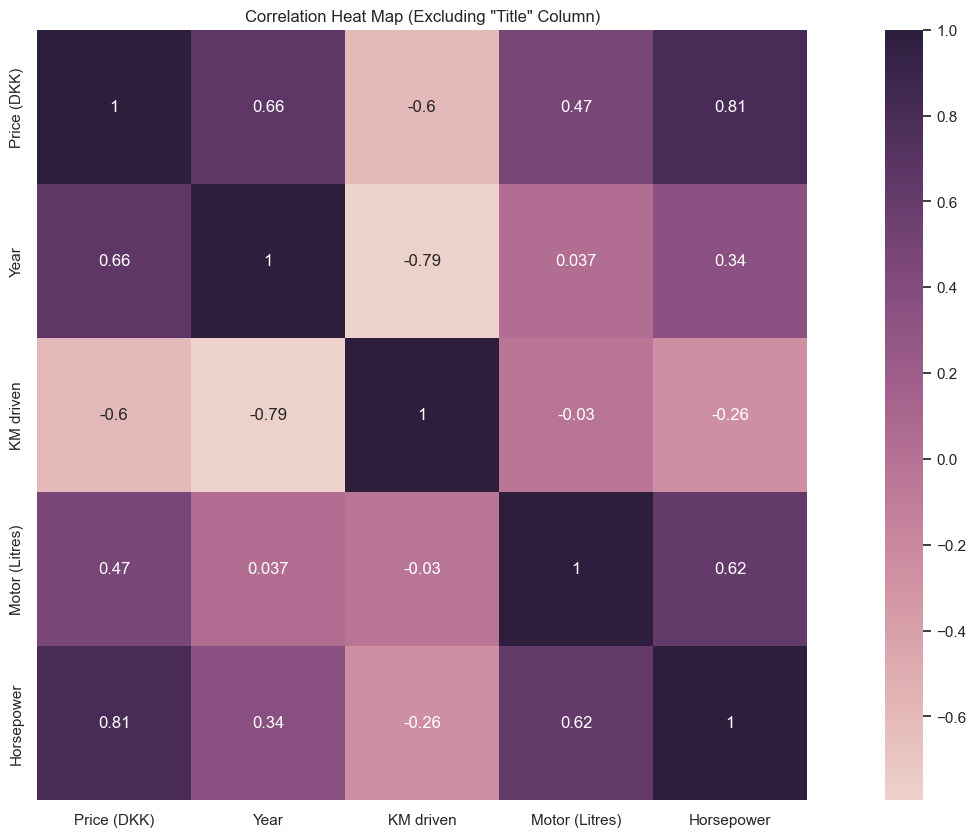

In [ ]:

final_data_without_title = final_data.drop(columns=["Title", 'Transmission','Car Manufacturer', 'Country of Origin'])

# Generate the correlation heatmap
sns.heatmap(final_data_without_title.corr(), cmap=sns.cubehelix_palette(as_cmap=True), annot=True, cbar=True, square=True)
plt.title('Correlation Heat Map (Excluding "Title" Column)')
plt.savefig('Correlation Heat Map.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


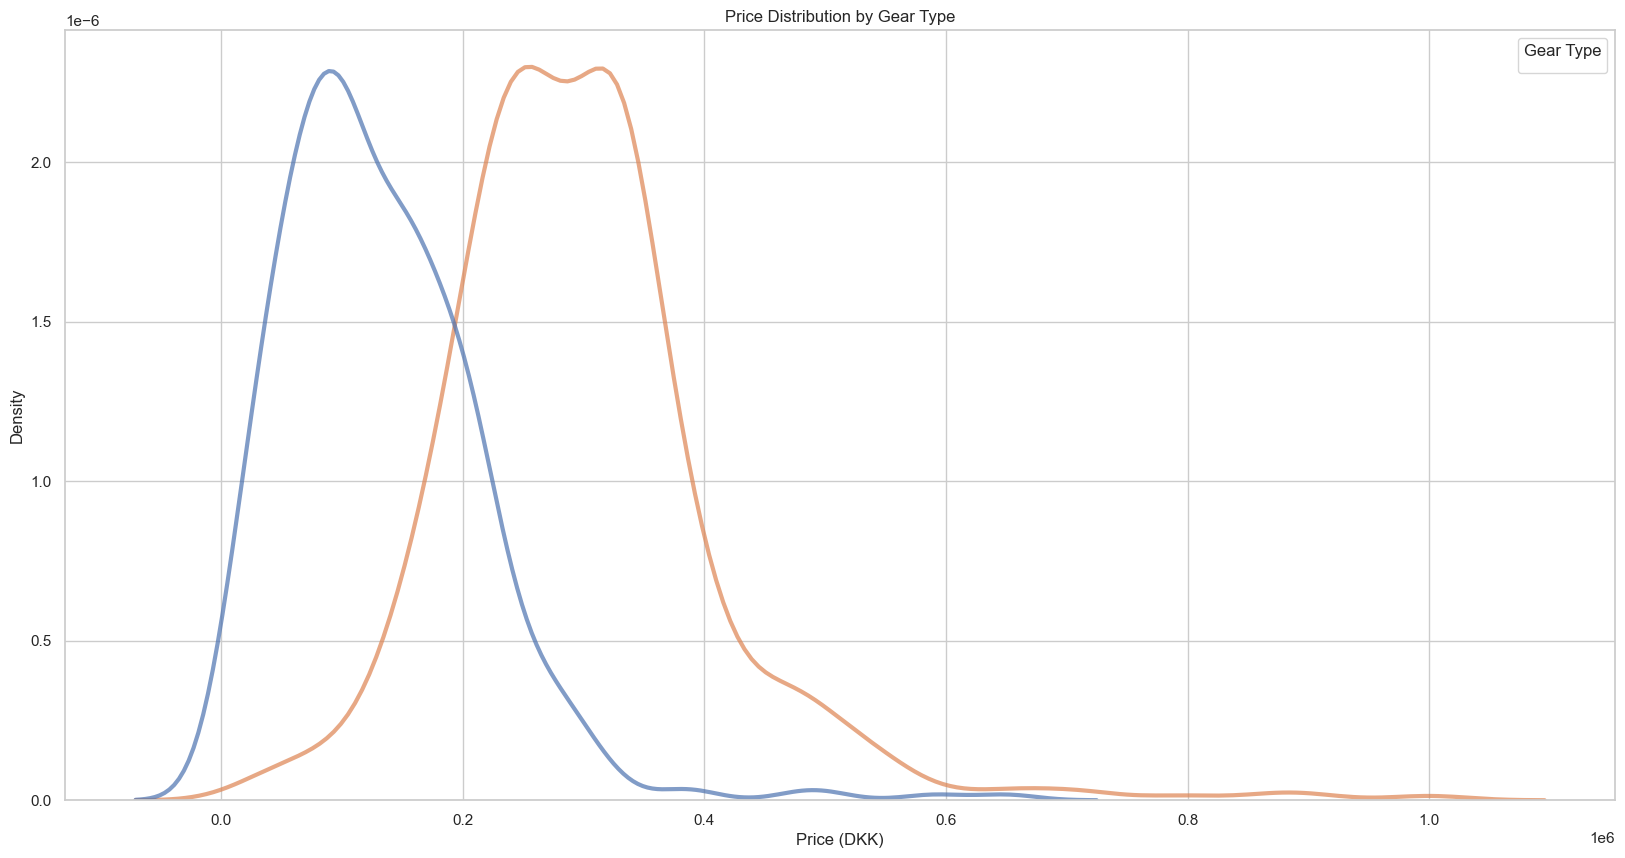

In [ ]:
sns.kdeplot(data=final_data, x="Price (DKK)", hue="Transmission", multiple="layer", linewidth=3, alpha=0.7)
plt.title("Price Distribution by Gear Type")
plt.xlabel("Price (DKK)")
plt.ylabel("Density")

# Add legend
plt.legend(title="Gear Type")

# Show the plot
plt.show()


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


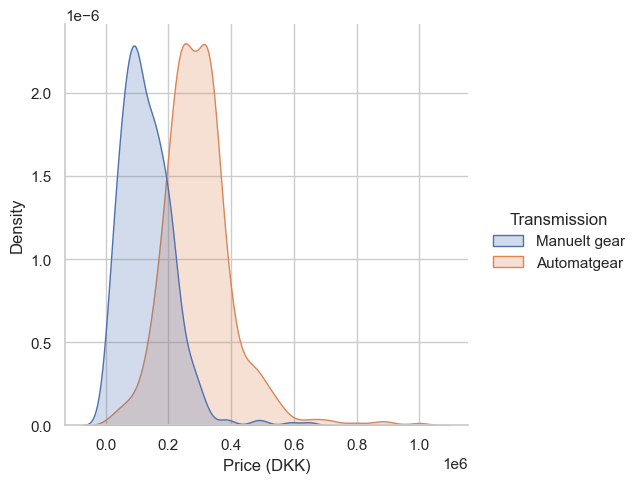

In [ ]:
sns.displot(data=final_data, x="Price (DKK)", hue="Transmission", kind="kde", fill=True)


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


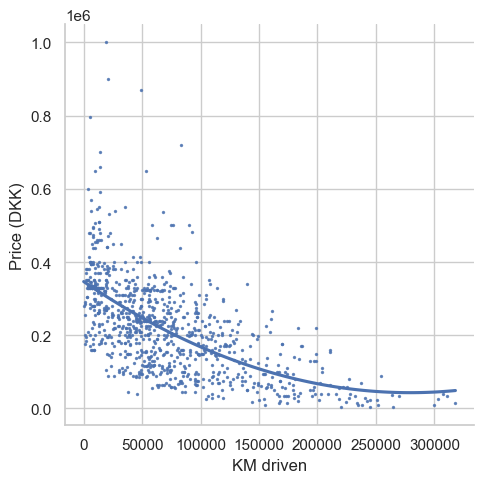

In [ ]:
sns.lmplot(x="KM driven", y="Price (DKK)", data=final_data,
           order=2, ci=None, scatter_kws={"s": 2});

<Axes: xlabel='Price (DKK)', ylabel='KM driven'>

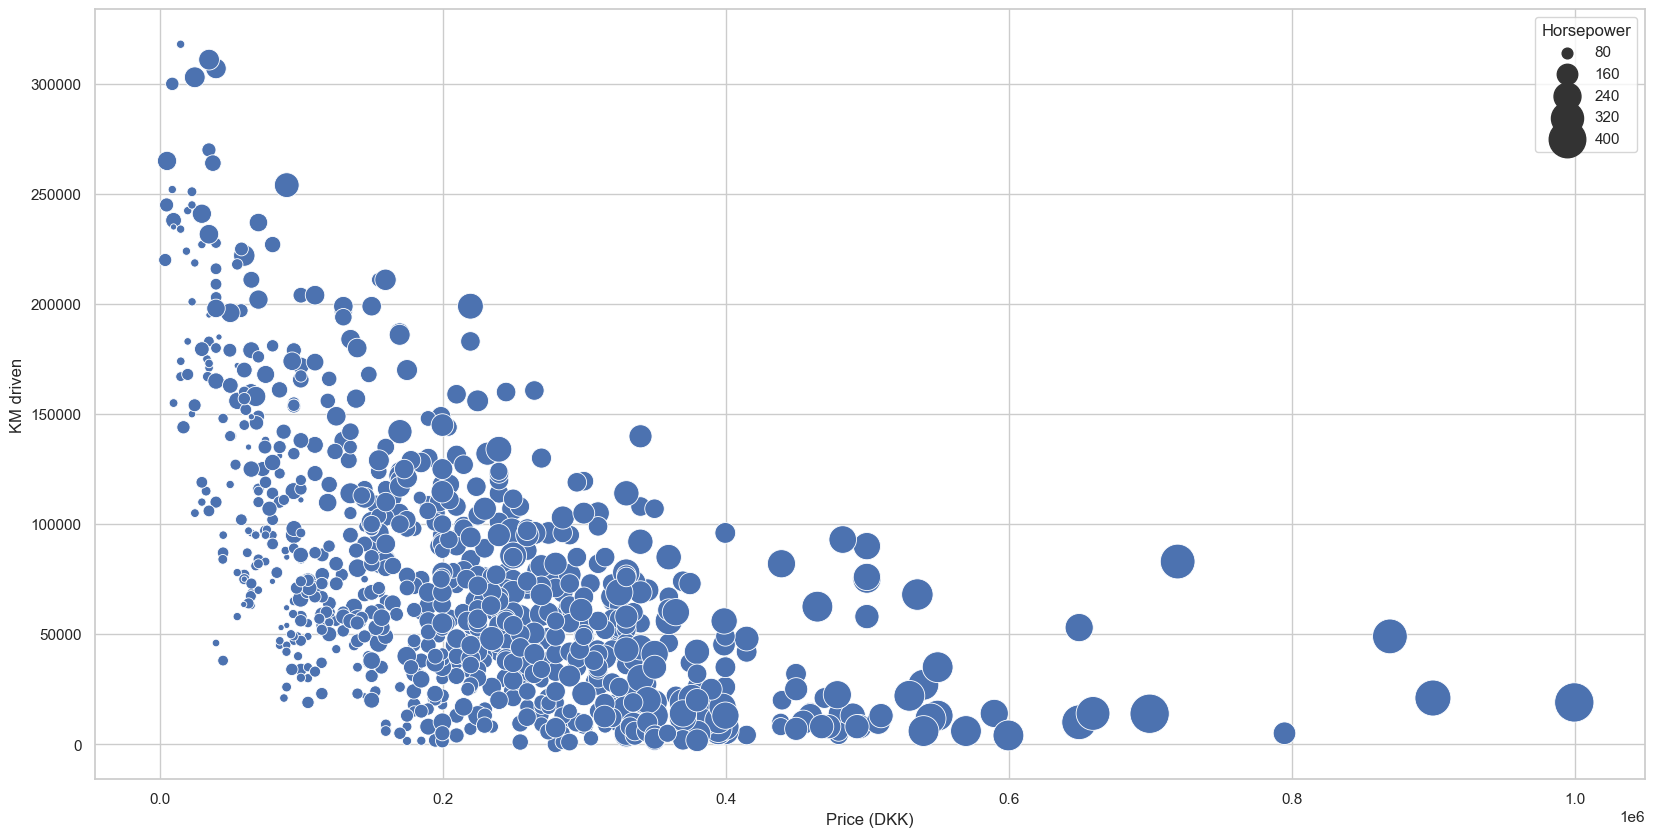

In [ ]:
sns.scatterplot(
    data=final_data, x="Price (DKK)", y="KM driven", size="Horsepower",
    sizes=(20, 800)
)



C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


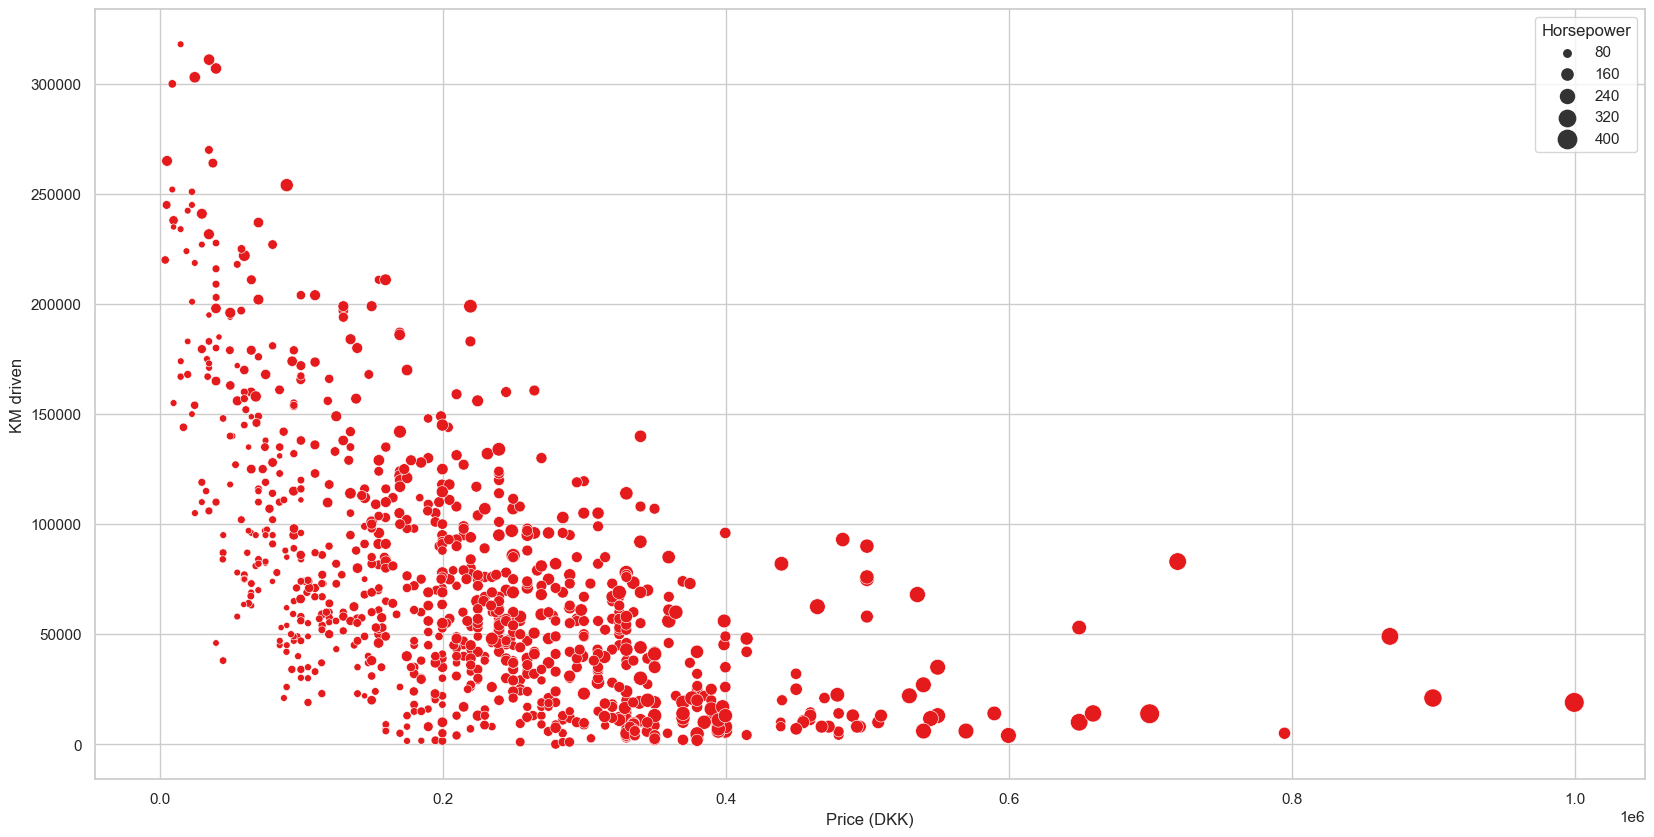

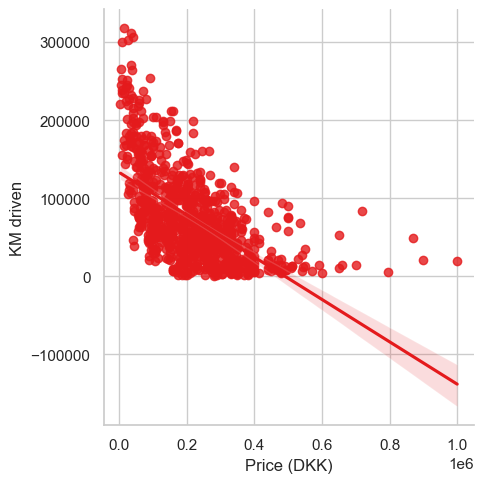

In [ ]:
sns.set_palette("Set1")

# Create the scatter plot
scatter_plot = sns.scatterplot(
    data=final_data, x="Price (DKK)", y="KM driven",
    size="Horsepower",
    sizes=(20, 200)
)
sns.lmplot(data=final_data, x="Price (DKK)", y="KM driven")


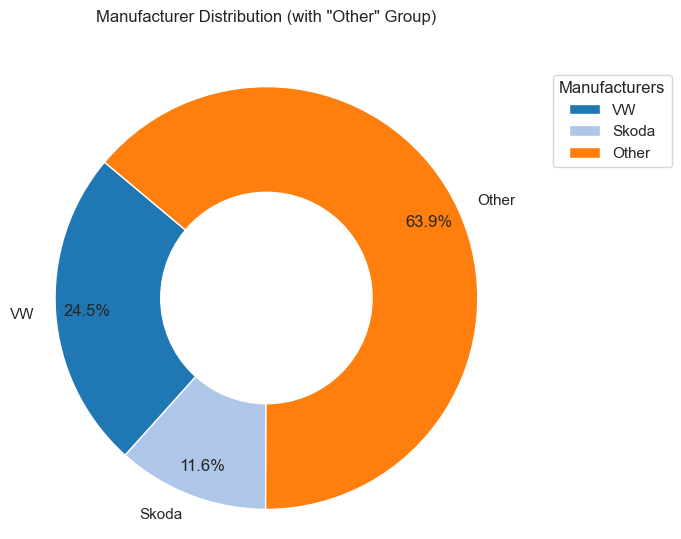

In [ ]:
colors = sns.color_palette('pastel')

#create pie chart
manufacturer_counts = final_data['Car Manufacturer'].value_counts()

threshold = 100

# Find groups with counts below the threshold
small_groups = manufacturer_counts[manufacturer_counts < threshold]

# Replace small groups with 'Other'
manufacturer_counts['Other'] = small_groups.sum()
manufacturer_counts.drop(small_groups.index, inplace=True)

colors = plt.cm.tab20.colors

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=140,
        colors=colors, shadow=False, pctdistance=0.85)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Manufacturer Distribution (with "Other" Group)',y=1.08)
plt.legend(title='Manufacturers', loc='upper left', bbox_to_anchor=(1.1, 1))
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

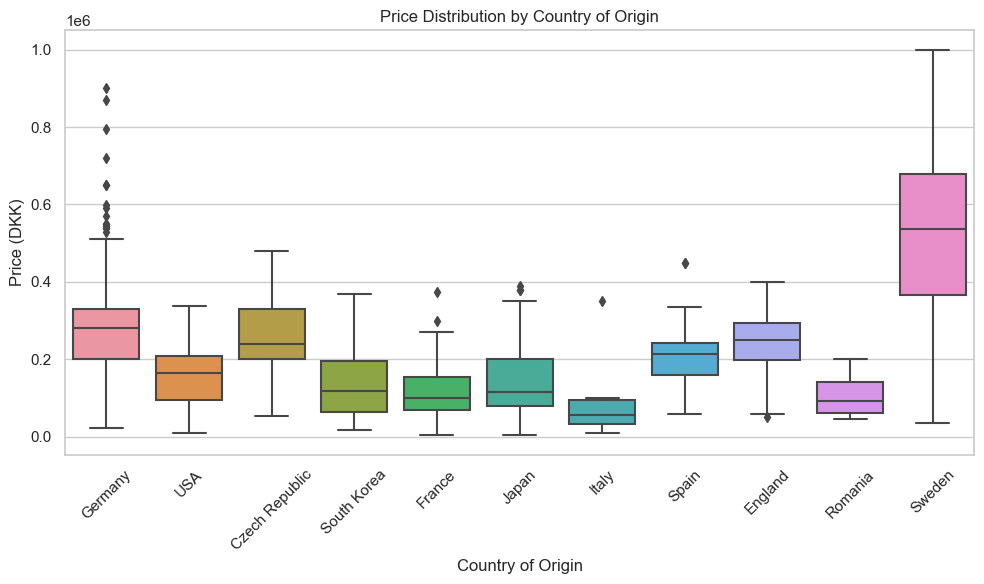

In [ ]:
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Set the size of the plot

# Create the boxplot using seaborn
sns.boxplot(data=final_data, x='Country of Origin', y='Price (DKK)')


plt.title('Price Distribution by Country of Origin')
plt.xlabel('Country of Origin')
plt.ylabel('Price (DKK)')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

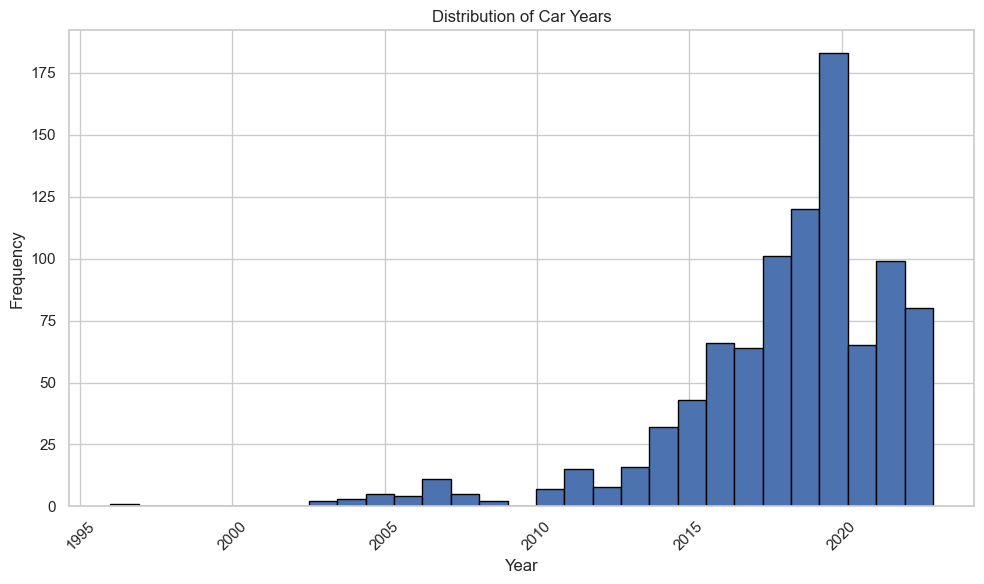

In [ ]:
plt.figure(figsize=(10, 6))  # Set the size of the plot

# Create the histogram using matplotlib
plt.hist(final_data['Year'], bins=29, edgecolor='black')

plt.title('Distribution of Car Years')
plt.xlabel('Year')
plt.ylabel('Frequency')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = final_data[['Year', 'KM driven', 'Motor (Litres)', 'Horsepower','Car Manufacturer', 'Transmission']]
y = final_data['Price (DKK)']

X = pd.get_dummies(X, columns=['Car Manufacturer','Transmission'])

# SPLIT INTO DEVELOPMENT (2/3) AND TEST DATA (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)

# SPLIT DEVELOPMENT INTO TRAIN (1/3) AND VALIDATION (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=161193)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(f'ez',r2)

ez 0.8869465841797697


In [ ]:
coefficients = model.coef_

# Create a dictionary to map feature names to coefficients
feature_coefficients = dict(zip(X.columns, coefficients))

# Print the coefficients for each feature
for feature, coefficient in feature_coefficients.items():
    print(f'{feature}: {coefficient}')

Year: 10500.436628492966
KM driven: -0.40122726676827325
Motor (Litres): 9509.935799580117
Horsepower: 1157.9810445019768
Car Manufacturer_Alfa: -2.473825588822365e-10
Car Manufacturer_Audi: 17556.710026461125
Car Manufacturer_BMW: 12490.696209548416
Car Manufacturer_Chevrolet: 970.73758356876
Car Manufacturer_Citroën: -26543.326196152975
Car Manufacturer_Cupra: 2.9103830456733704e-11
Car Manufacturer_Dacia: -38650.78807504049
Car Manufacturer_Fiat: 19376.114754013484
Car Manufacturer_Ford: -18979.473781153287
Car Manufacturer_Honda: -28583.33651210275
Car Manufacturer_Hyundai: -19085.62664775154
Car Manufacturer_Kia: -2900.1045490517236
Car Manufacturer_Mazda: -1433.208995333496
Car Manufacturer_Mercedes: 88779.96834813876
Car Manufacturer_Mini: 30967.92849125829
Car Manufacturer_Mitsubishi: -58028.07848895385
Car Manufacturer_Nissan: -19809.00754830935
Car Manufacturer_Opel: -25283.07376499449
Car Manufacturer_Peugeot: -9109.243184355124
Car Manufacturer_Renault: -21887.1975229835
Ca

In [ ]:
from sklearn.linear_model import Lasso
# Create and fit the Lasso model
lasso_model = Lasso(alpha=1)  # You can adjust the alpha value
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred1 = lasso_model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared (Lasso):', r2)

NameError: name 'X_train' is not defined

In [ ]:
# Get the learned coefficients
lasso_coefficients = lasso_model.coef_

# Create a dictionary to map feature names to coefficients
feature_coefficients = dict(zip(X.columns, lasso_coefficients))

# Print the coefficients for each feature
for feature, coefficient in feature_coefficients.items():
    print(f'{feature}: {coefficient}')

Year: 10499.347167451537
KM driven: -0.4012093878448158
Motor (Litres): 9507.071521837039
Horsepower: 1158.3610529374557
Car Manufacturer_Alfa: 0.0
Car Manufacturer_Audi: 19858.591710791876
Car Manufacturer_BMW: 14767.265206759943
Car Manufacturer_Chevrolet: 3002.166683108713
Car Manufacturer_Citroën: -24141.909769265345
Car Manufacturer_Cupra: 0.0
Car Manufacturer_Dacia: -36198.1598076228
Car Manufacturer_Fiat: 21618.88563384244
Car Manufacturer_Ford: -16628.375516840755
Car Manufacturer_Honda: -26160.028161281076
Car Manufacturer_Hyundai: -16692.37425502755
Car Manufacturer_Kia: -505.6258995135617
Car Manufacturer_Mazda: 853.0463390321618
Car Manufacturer_Mercedes: 91070.38826870918
Car Manufacturer_Mini: 33257.21631993019
Car Manufacturer_Mitsubishi: -55397.828236691515
Car Manufacturer_Nissan: -17443.296391486663
Car Manufacturer_Opel: -22915.73428070018
Car Manufacturer_Peugeot: -6752.217915836368
Car Manufacturer_Renault: -19508.046753041785
Car Manufacturer_Saab: 0.0
Car Manufac

In [ ]:
from sklearn.linear_model import ElasticNet
elasticnet_model = ElasticNet(alpha=1, l1_ratio=.5)  # You can adjust the alpha and l1_ratio values
elasticnet_model.fit(X_train, y_train)

# Make predictions
y_pred = elasticnet_model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared (ElasticNet):', r2)

R-squared (ElasticNet): 0.8483383668604312


In [ ]:
elasticnet_coefficients = elasticnet_model.coef_

# Create a dictionary to map feature names to coefficients
feature_coefficients = dict(zip(X.columns, elasticnet_coefficients))

# Print the coefficients for each feature
for feature, coefficient in feature_coefficients.items():
    print(f'{feature}: {coefficient}')

Year: 9325.150330608127
KM driven: -0.46178397166464885
Motor (Litres): 1200.9997839136497
Horsepower: 1492.7518800978921
Car Manufacturer_Alfa: 0.0
Car Manufacturer_Audi: 281.7236004077734
Car Manufacturer_BMW: 29.024628526732858
Car Manufacturer_Chevrolet: 63.6852174213772
Car Manufacturer_Citroën: -860.9365961519429
Car Manufacturer_Cupra: 0.0
Car Manufacturer_Dacia: -645.2443716906158
Car Manufacturer_Fiat: 482.4363866030577
Car Manufacturer_Ford: -2347.000333722864
Car Manufacturer_Honda: -768.3114361685946
Car Manufacturer_Hyundai: -738.9640841357059
Car Manufacturer_Kia: 11.810446376415547
Car Manufacturer_Mazda: -484.79149507992764
Car Manufacturer_Mercedes: 5323.415749964061
Car Manufacturer_Mini: 1149.9437966275486
Car Manufacturer_Mitsubishi: -438.456620835648
Car Manufacturer_Nissan: -1479.6098184045447
Car Manufacturer_Opel: -1841.223809688666
Car Manufacturer_Peugeot: -848.6156874167748
Car Manufacturer_Renault: -991.4498108116513
Car Manufacturer_Saab: 0.0
Car Manufactur

In [ ]:
from sklearn.model_selection import cross_val_score

# Load and prepare your data
# X and y are your feature matrix and target variable

# Perform cross-validation with 5 folds
cross_val_score1 = cross_val_score(model, X, y, cv=5, scoring='r2')
cross_val_score2 = cross_val_score(lasso_model, X, y, cv=5, scoring='r2')
cross_val_score3 = cross_val_score(elasticnet_model, X, y, cv=5, scoring='r2')

cross_val_scores = [cross_val_score1, cross_val_score2, cross_val_score3]
# Print the R-squared scores for each fold
for i, cross_val_score in enumerate(cross_val_scores):
    print("Cross-Validation R-squared scores:", cross_val_scores)
for i in range(3):
    print("Average R-squared:", cross_val_score[i].mean())

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.908e+10, tolerance: 1.150e+09
  model = cd_fast.enet_coordinate_descent(


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e+11, tolerance: 1.370e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.582e+10, tolerance: 1.150e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

Cross-Validation R-squared scores: [array([0.54304362, 0.84828736, 0.83823741, 0.76762624, 0.88443843]), array([0.49896314, 0.85789199, 0.83197264, 0.8007353 , 0.88569536]), array([0.60781597, 0.8011217 , 0.76896181, 0.77837828, 0.89474932])]
Cross-Validation R-squared scores: [array([0.54304362, 0.84828736, 0.83823741, 0.76762624, 0.88443843]), array([0.49896314, 0.85789199, 0.83197264, 0.8007353 , 0.88569536]), array([0.60781597, 0.8011217 , 0.76896181, 0.77837828, 0.89474932])]
Cross-Validation R-squared scores: [array([0.54304362, 0.84828736, 0.83823741, 0.76762624, 0.88443843]), array([0.49896314, 0.85789199, 0.83197264, 0.8007353 , 0.88569536]), array([0.60781597, 0.8011217 , 0.76896181, 0.77837828, 0.89474932])]
Average R-squared: 0.6078159663107578
Average R-squared: 0.8011216969107838
Average R-squared: 0.7689618091089174


In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error as mse

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(-4, 4, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso1 = make_pipeline(PolynomialFeatures(degree=2),
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=161193))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])



NameError: name 'Lasso' is not defined

In [ ]:
perform = [] # Store performance
lambdas = np.logspace(-4, 4, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso2 = make_pipeline(PolynomialFeatures(degree=2),
                               StandardScaler(),
                               ElasticNet(alpha=lambda_, random_state=161193))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 0.0001
Validation MSE: 33335547695599731449384520226960788422656.000


In [ ]:
perform = [] # Store performance
lambdas = np.logspace(-4, 4, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso0 = make_pipeline(PolynomialFeatures(),
                               StandardScaler(),
                               LinearRegression())
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)
print('Validation MSE: %.3f' % optimal.values[0])

Validation MSE: 33335547695599731449384520226960788422656.000


In [ ]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=102)
folds = list(kfolds.split(X_dev, y_dev))

# Outer loop: lambdas
mseCV = []
for lambda_ in lambdas:
    # Inner loop: folds
    mseCV_ = []
    for train_idx, val_idx in folds:
        # Check indices validity
        if train_idx.max() >= X_dev.shape[0] or val_idx.max() >= X_dev.shape[0]:
            print("Invalid indices detected!")
            continue
        
        # Train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(
            PolynomialFeatures(degree=2, include_bias=True),
            StandardScaler(),
            Lasso(alpha=lambda_, random_state=161193)
        )
        
        X_train, y_train = X_dev.iloc[train_idx].values, y_dev.iloc[train_idx].values
        X_val, y_val = X_dev.iloc[val_idx].values, y_dev.iloc[val_idx].values 
        
        pipe_lassoCV.fit(X_train, y_train)
        
        mseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))
    
    # Store result    
    mseCV.append(mseCV_) 

# Convert to DataFrame
lambdaCV = pd.DataFrame(mseCV, index=lambdas)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.322e+11, tolerance: 1.067e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.313e+11, tolerance: 1.059e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse

# ... Assuming X_dev, y_dev, X_test, y_test, and lambdaCV are defined ...

# Choose optimal hyperparameters
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)

# Retrain/re-estimate model using optimal hyperparameters and compare performance
pipe_lassoCV = make_pipeline(
    PolynomialFeatures(include_bias=False), 
    StandardScaler(),
    Lasso(alpha=optimal_lambda.index[0], random_state=161193)
)

# Fit PolynomialFeatures to X_dev
poly = PolynomialFeatures(include_bias=False)
X_dev_poly = poly.fit_transform(X_dev)

# Fit and transform the rest of the pipeline
pipe_lassoCV.fit(X_dev_poly, y_dev)
pipe_lasso1.fit(X_dev_poly, y_dev)
pipe_lasso0.fit(X_dev_poly, y_dev)
# Transform X_test using the fitted PolynomialFeatures
X_test_poly = poly.transform(X_test)

models = {'Lasso': pipe_lasso1, 'Lasso CV': pipe_lassoCV, 'LinReg': pipe_lasso0}
for name, model in models.items():
    score = mse(model.predict(X_test_poly), y_test)
    print(name, round(score, 2))

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.757e+09, tolerance: 1.076e+09
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.418e+09, tolerance: 1.076e+09
  model = cd_fast.enet_coordinate_descent(


Lasso 2139993486.5
Lasso CV 1646717881.31
LinReg 3.8324485769743083e+34


In [ ]:

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

mse_.head(5)


Train          Test
sample size                            
27           8.763921e-19  8.820068e+11
55           1.077783e+07  5.613800e+16
83           1.673082e+08  7.352099e+37
111          2.848676e+08  1.221770e+41
139          2.693267e+08  5.549272e+38

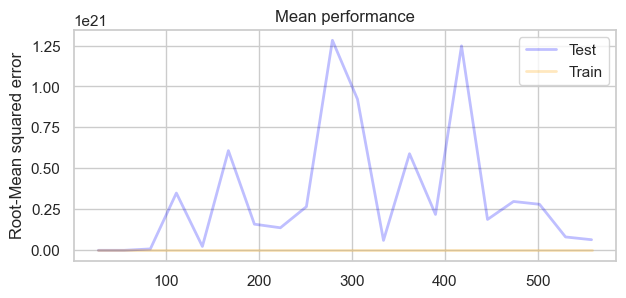

In [ ]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.plot(train_sizes,np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
ax.plot(train_sizes,np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

ax.set_title('Mean performance')
ax.set_ylabel('Root-Mean squared error')
ax.legend();


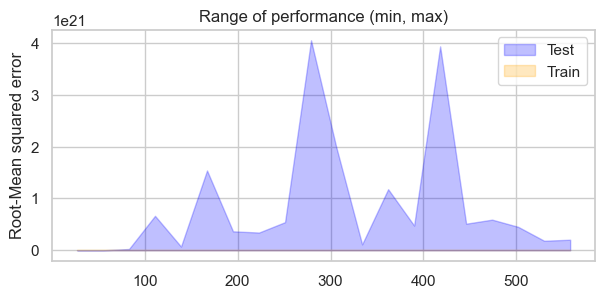

In [ ]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.fill_between(train_sizes, np.sqrt(-test_scores.min(1)), np.sqrt(-test_scores.max(1)), alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes, np.sqrt(-train_scores.min(1)), np.sqrt(-train_scores.max(1)),  alpha=0.25, label='Train', color='orange')

ax.set_title('Range of performance (min, max)')
ax.set_ylabel('Root-Mean squared error')
ax.legend();

In [ ]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso1,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', 
                     param_range=lambdas, 
                     scoring='neg_mean_squared_error',                 
                     cv=10)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.008e+11, tolerance: 9.633e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.008e+11, tolerance: 9.633e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

lambda
4273.357542    2.304646e+09
Name: Validation, dtype: float64


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.326e+09, tolerance: 9.328e+08
  model = cd_fast.enet_coordinate_descent(


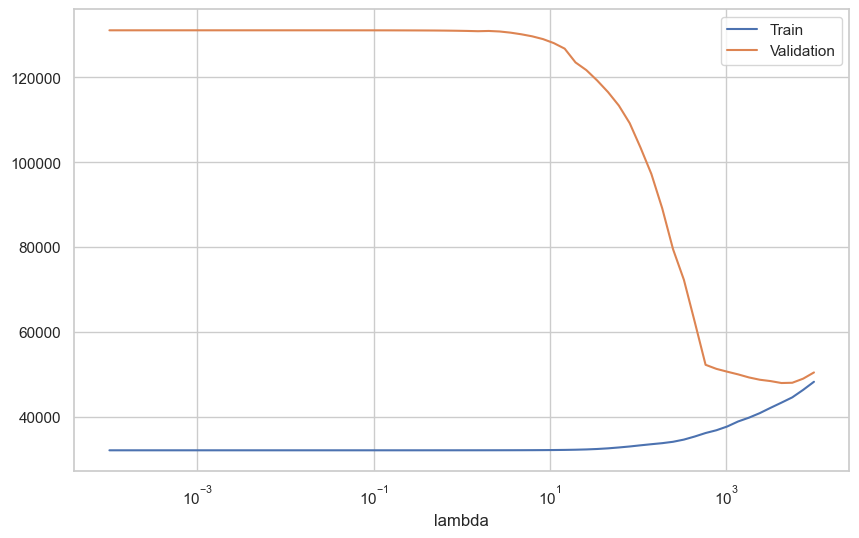

In [ ]:
np.sqrt(mse_score).plot(logx=True, figsize=(10,6));

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

pipe_el = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        ElasticNet())

gs = GridSearchCV(estimator=pipe_el, 
                  param_grid={'elasticnet__alpha':lambdas,
                              'elasticnet__l1_ratio':np.linspace(0,1,20)}, 
                  scoring='neg_mean_squared_error', 
                  cv=10)

models['ElasicNetCV'] = gs.fit(X_dev_poly, y_dev)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e+11, tolerance: 9.633e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 

In [ ]:
for name, model in models.items():
    score = mse(model.predict(X_test_poly),y_test)
    print(name, round(score, 2))
print()
print('CV params:', gs.best_params_)

Lasso 2139993486.5
Lasso CV 1646717881.31
LinReg 3.8324485769743083e+34
Error while evaluating model ElasicNetCV: X has 629 features, but PolynomialFeatures is expecting 34 features as input.

CV params: {'elasticnet__alpha': 0.8678837132695973, 'elasticnet__l1_ratio': 0.7368421052631579}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
